# Idea
    at first we want to extract a features and based on that  get the info

First, which model should we choose for the Image pretrining? 
if you ask LLM's VGG is no brainer, thats because they have feed too many github repos which uses VGG to solve this problem, but in reality we can far better and newer models, as for me , i am choosing efficentNets, smaller lower FLOP's, lower resources better results,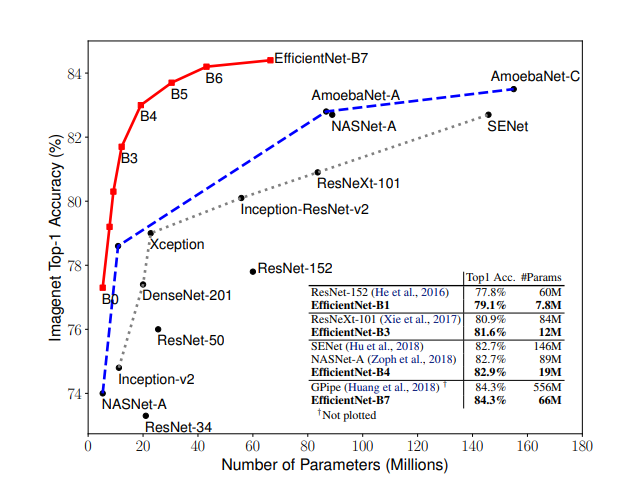,

i am using collab, assume you have the zip file on collab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Change to the directory where your zip file is located (e.g., My Drive)
%cd /content/drive/My Drive/

In [ ]:
# Unzip the file
!unzip caption_data.zip

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as T
from torchvision import models
from PIL import Image
import pandas as pd
import numpy as np
from collections import Counter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# could be modified
class Config:
    # Paths
    IMAGE_DIR = "caption_data/Images"
    CAPTIONS_FILE = "caption_data/captions.txt"
    FEATURES_PATH = "caption_data/resnet_features.pt"
    
    # Model
    EMBED_SIZE = 256
    HIDDEN_SIZE = 512
    NUM_LAYERS = 1
    DROPOUT = 0.5
    
    # Training
    BATCH_SIZE = 64
    EPOCHS = 20
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-5
    GRAD_CLIP = 5.0
    
    # Data
    FREQ_THRESHOLD = 5  # could be modified
    MAX_SEQ_LEN = 50
    
    # Splits
    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1

cfg = Config()

In [ ]:
train_transform = T.Compose([
    T.Resize((288, 288)),
    # T.RandomCrop((224, 224)), we can do that, but what if it crops the small neededed object
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)), too brutal
    T.RandomGrayscale(p=0.02), # we can delete it because the color is important for us, we do not grey sky output
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # efficent Net is using Imagenet data for the training so using these values here wont be a data leakage because these are the values of the Imagenet, even though our data could be different this values work well  
])

# no shenanigans for this one
val_transform = T.Compose([
    T.Resize((260, 260)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
class EfficientNetEncoder(nn.Module):
    """
    EfficientNet-B2 feature extractor - COMPLETELY FROZEN
    Only the projection layer is trainable
    """
    def __init__(self, embed_size):
        super().__init__()
        
        # Load pretrained EfficientNet-B2
        effnet = models.efficientnet_b2(
            weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1
        )
        
        # EfficientNet structure:
        # features -> avgpool -> classifier
        self.backbone = effnet.features
        self.avgpool = effnet.avgpool
        
        # Feature dimension for B2
        backbone_out = 1408
        
        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Projection head (trainable)
        self.projection = nn.Sequential(
            nn.Flatten(),
            nn.Linear(backbone_out, embed_size),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def forward(self, images):
        with torch.no_grad():
            x = self.backbone(images)
            x = self.avgpool(x)
        
        features = self.projection(x)
        return features
